# 1D spectral extraction using aperture photometry on an extended source observation
In this notebook we illustrate how to perform aperture photometry on LVL2 MRS data products (slope detector images). The algorithm is applied to an extended source observation of an 800K blackbody source observed in all MRS spectral bands.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
from distortionMaps import d2cMapping
from shapely.geometry import Point
import shapely.affinity

from numpy import zeros,where
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# Define filename of observation in selected MRS band
sci_files = {"1A":lvl2path +'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits',
            "1B":lvl2path +'FM1T00011283/MIRFM1T00011283_1_495_SE_2011-05-31T03h12m30_LVL2.fits',
            "1C":lvl2path +'FM1T00011284/MIRFM1T00011284_1_495_SE_2011-05-31T04h09m25_LVL2.fits',
            "2A":lvl2path +'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits',
            "2B":lvl2path +'FM1T00011283/MIRFM1T00011283_1_495_SE_2011-05-31T03h12m30_LVL2.fits',
            "2C":lvl2path +'FM1T00011284/MIRFM1T00011284_1_495_SE_2011-05-31T04h09m25_LVL2.fits',
            "3A":lvl2path +'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits',
            "3B":lvl2path +'FM1T00011283/MIRFM1T00011283_1_494_SE_2011-05-31T03h11m59_LVL2.fits',
            "3C":lvl2path +'FM1T00011284/MIRFM1T00011284_1_494_SE_2011-05-31T04h08m55_LVL2.fits',
            "4A":lvl2path +'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits',
            "4B":lvl2path +'FM1T00011283/MIRFM1T00011283_1_494_SE_2011-05-31T03h11m59_LVL2.fits',
            "4C":lvl2path +'FM1T00011284/MIRFM1T00011284_1_494_SE_2011-05-31T04h08m55_LVL2.fits'}

aperture_radius = 1. # arcsecond

In [ ]:
wavelength,aperture_extracted_signal = {},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    # Get data
    hdulist_sci   = fits.open(sci_files[band])
    source_signal = hdulist_sci[0].data[0,:,:]
    background_signal = 0

    # load distortion map on detector plane
    d2cMaps  = d2cMapping(band,cdpDir)
    det_dims = (1024,1032)

    # load CDPS
    fringe_img,photom_img,pixsiz_img,psffits,specres_table = funcs.get_cdps(band,cdpDir,output='img')

    # reduce LVL2 data to LVL3 data
    source_signal_subtrbkg  = source_signal - background_signal     # [DN/s/pix_{ij}]
    source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]
    source_signal_divphotom = source_signal_divfringe/photom_img    # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)
    source_signal_divpixsiz = source_signal_divphotom/pixsiz_img    # [mJy/arcsec^2]

    # create spectral grid on detector
    lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

    # define aperture shape
    # 1st elem = center point (x,y) coordinates
    # 2nd elem = the two semi-axis values (along x, along y)
    # 3rd elem = angle in degrees between x-axis of the Cartesian base
    #            and the corresponding semi-axis
    ellipse = ((0, 0),(1, 1),0)

    # Let create a circle of radius 1 around center point:
    circ = shapely.geometry.Point(ellipse[0]).buffer(aperture_radius)

    # Let create the ellipse along x and y:
    ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellr = shapely.affinity.rotate(ell,ellipse[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellr
    aperture_area = aperture.area

    # create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
    weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

    # perform 1d aperture extraction
    extracted_signal = funcs.aperture_weighted_photometry_extended_source(source_signal_divpixsiz,weight_map,aperture_area,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms])

    wavelength[band] = lambcens
    aperture_extracted_signal[band] = extracted_signal
    print ''
print 'DONE'

<IPython.core.display.Javascript object>


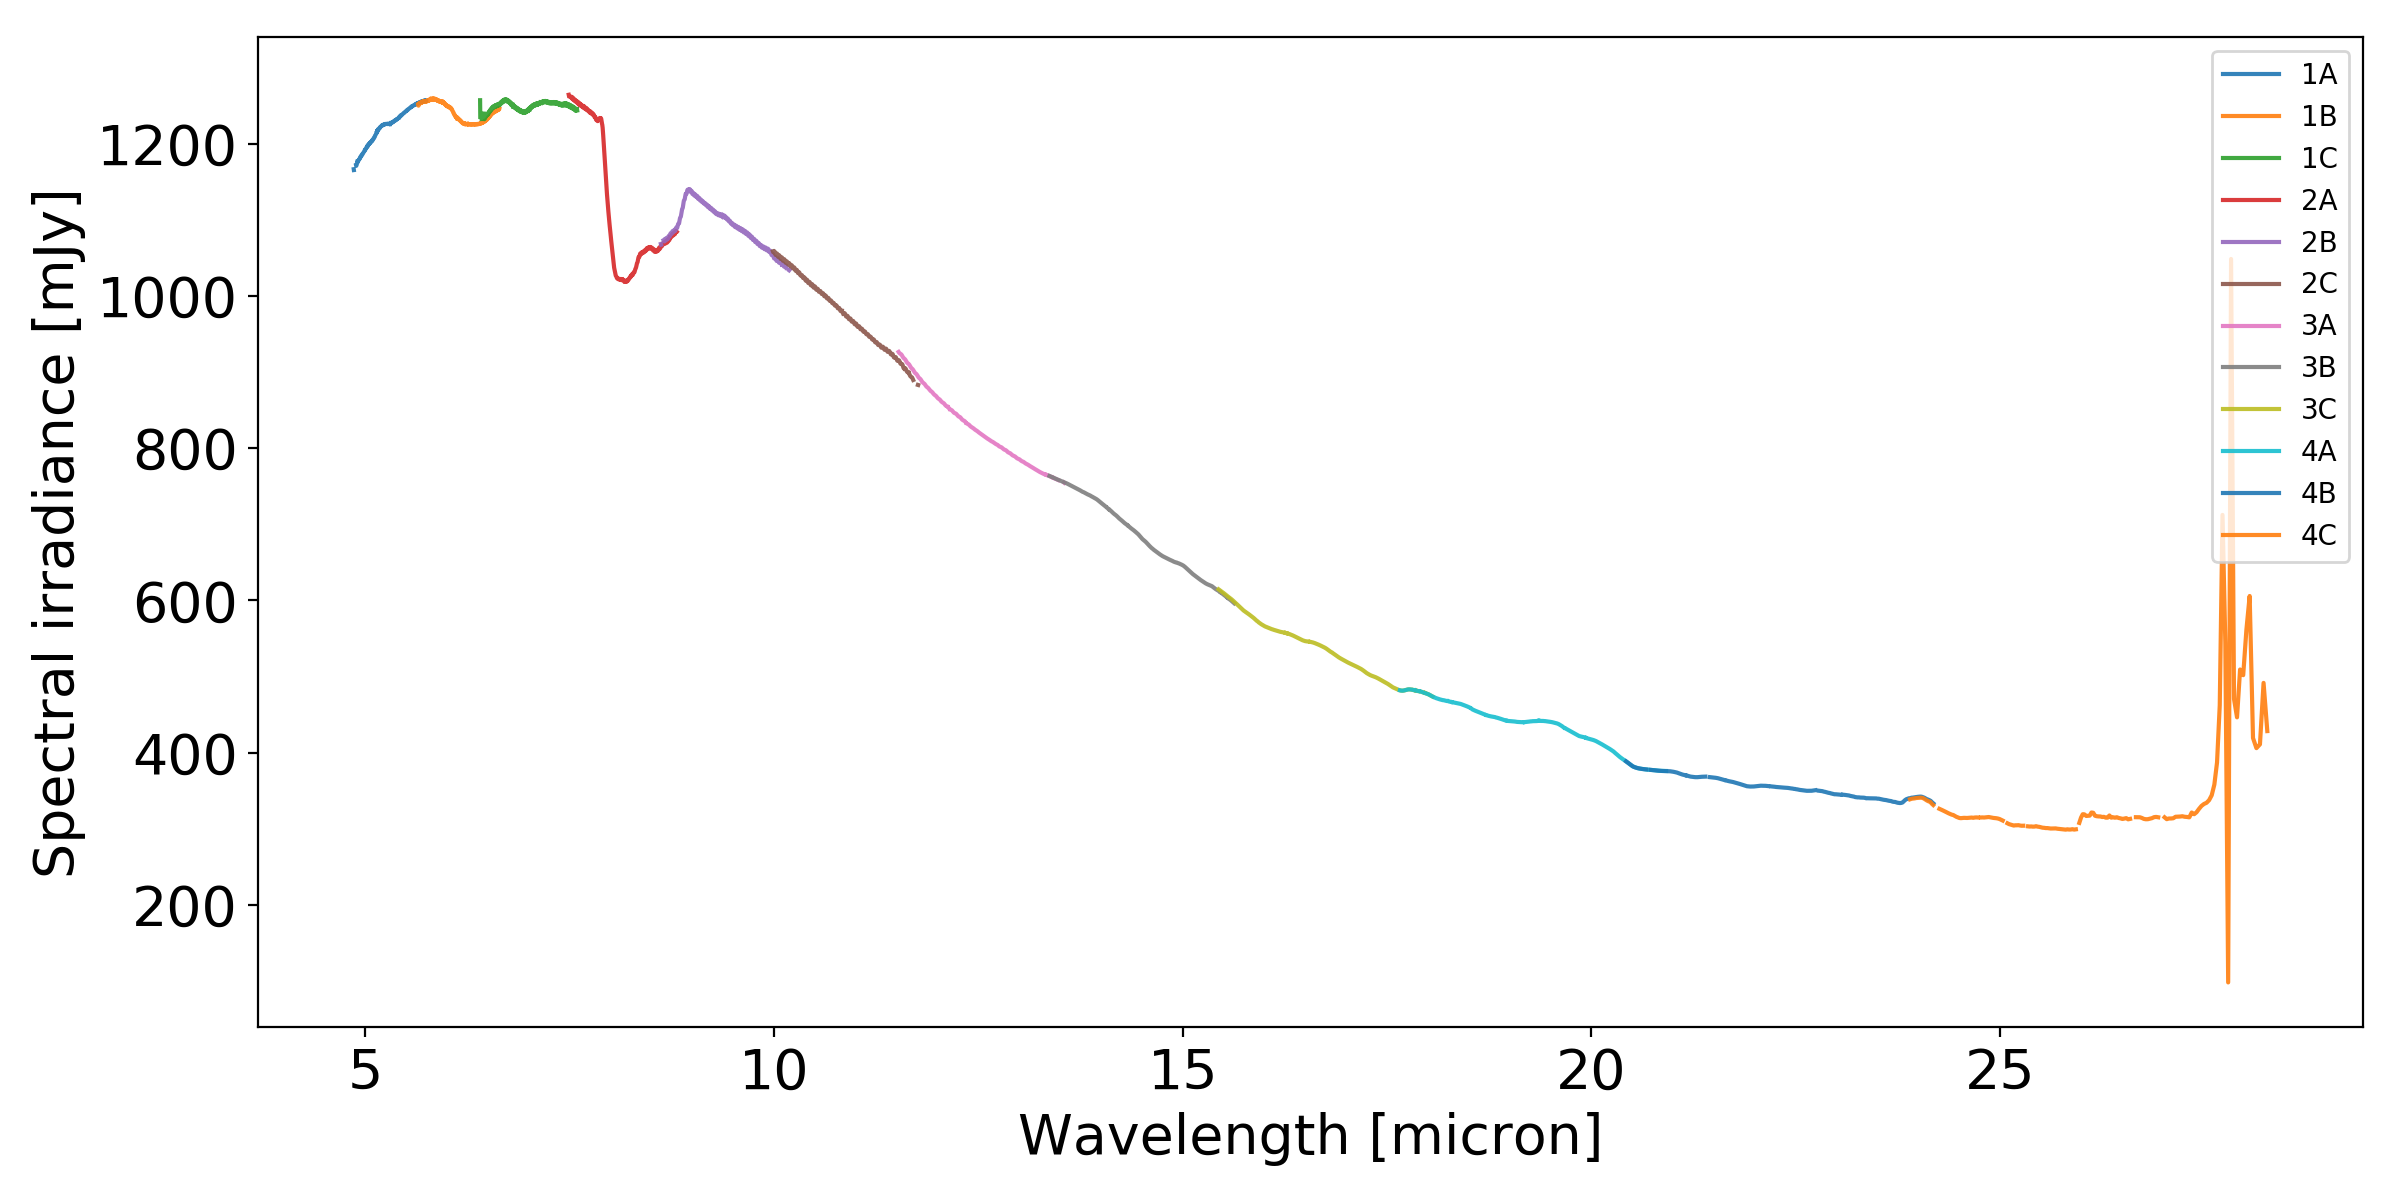

In [17]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    plt.plot(wavelength[band],aperture_extracted_signal[band],alpha=0.9,label=band)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.legend(loc='upper right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()